### Github commands

```
git add -uv    #v, verbose; u, only update tracked files
git commit -av
git ls-tree -r master
```

```
watch "lsof -p 1511|grep /dev/shm/|wc -l;lsof -p 1511|wc -l"
```

### Monte Carlo Tree Search
![Monte Carlo Tree Search](./old_useless_codes/MCTS.png)


### 2020 Nov 1th

Try to organize legacy codes. Organized Util, OfflineInterface, MrRandom, MrIf, MrNN. 

MrGreed and MrNN_Trainer are still to be read.

### 2020 Nov 6th

Understaned MrGreed, added detailed comments, tested its ability. Combating with MrIf, N_SAMPLE=20, MrGreed can win $85.26\pm8.09$.

### 2020 Nov 7th

Finally realized MrO, a Q-learning AI.

### 2020 Nov 17th

Before alternating sampling algorithm, do the last benchmark for MrGreed. The code at this point is also backuped to github [commit 9e7eb50](https://github.com/Gongzhu-Society/MrIfOffline/commit/9e7eb509badf56fd014a18c896375d17e91e745c). Combat against MrIf with 1024x2 rounds.

$N_{sample}$    |5             |10            |20            |40
:--------------:|:------------:|:------------:|:------------:|:------------:
Points over MrIf|$71.82\pm5.76$|$75.41\pm5.55$|$83.73\pm5.62$|$86.44\pm5.63$
Time Comsumed   |61s           |114s          |218s          |419s

Here is the success rate for shot and test method.

Success Rate(percent)|#Restriction|#Cards remain
:-:|:-:|:-:
 6.33|2|18
10.64|2|14
14.29|3|11
 5.62|2|19
11.90|5|12
 4.03|5| 9

Here is a benchmark for shot and test method, with 1024x2 rounds.

$N_{sample}$    |5             |10            |20            |40
:--------------:|:------------:|:------------:|:------------:|:------------:
Points over MrIf|$68.33\pm5.72$|$82.21\pm5.73$|$96.32\pm5.68$|$80.61\pm5.52$
Time Comsumed   |90s           |144s          |300s          |696s

### 2020 Nov 21

New sampling algorithm is almost finished. It is time to do parameter tuning. I am going to test the time needed for: each shot and test, each table count and each construct by table. The result is in the following table. It is tested on an Intel i9-9960X.

Item                |Empty For Loop|Shot and Test                |Generate Tables   |Contruct by Table|
:------------------:|:------------:|:---------------------------:|:----------------:|:---------------:|
Time needed($\mu s$)|$0.014$       |$0.63*N_{cards\ remain}+1.01$|$80*N_{tables}$   |$~25$            |
Comment             |              |$R=0.97$                     |$\sigma\approx 10$|complicated      |

Now it is time for benchmarking! Preference is a parameter in codes. It indicates how much does ScenarioGen prefer constructing by table. The time is for 256x2 against two MrIf with 20 samples.

Preference|Shot and Test|-1000|-500|-200|-100|0  |100|200|500|1000|
:--------:|:-----------:|:---:|:--:|:--:|:--:|:-:|:-:|:-:|:-:|:--:|
Time(s)   |78           |67   |62  |60  |57  |57 |58 |58 |67 |74  |

### 2020 Dec 05
Finish __MrRandTree__, an MCTS AI with random rollout policy. The table below contains benchmarks for MrRandTree. Its scenario number is set to 5, iteration number to 200. MrIf's stats is from  stats in Appendix A. One can see that MrRandTree is rather strong.

|Item  |MrIf v.s. MrRandom|MrRandTree v.s. MrRandom|MrRandTree v.s. MrIf|MrRandTree v.s. MrGreed|
|:----:|:----------------:|:----------------------:|:------------------:|:---------------------:|
|Mode  |1 v.s. 3          |1 v.s. 3                |1 v.s. 3            |2 v.s. 2               |         
|Result|-2.3/87.8         |22.7/-88.2              |-29.4/-56.3         |-90.8/-92.3            |
|Sigma |1.5/2.7           |13.2/15.1               |20.3/13.6           |11.8/9.3               |
|Time  |                  |981s(16x4)              |1023s(16x4)         |7847s(128x2)           |

### 2020 Dec 12

将整个任务分为两步：1. 模仿 MrGreed；2. 从模仿的网络开始自己教自己。

为进行第一步，研究不同的网络结构对学习行为的影响，固定MrGreed产生数据的方法如 [9081cee](https://github.com/Gongzhu-Society/MrIfOffline/commit/9081ceebb75d6a128516476c62f697b1d3e85d70)，固定训练集大小为 (10x3)x52~1300，固定“复习移动窗口”为当前和上一次，固定网络结构、优化器参数、其他参数如

```
PV_NET [(Input_len, 1024), (1024, 1024), (1024, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 52), (256, 1)]
optimizer: {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-07, 'weight_decay': 0.0001, 'amsgrad': False}
LOSS2_WEIGHT: 0.0100, BETA: 0.20, VALUE_RENORMAL: 100, BENCHMARK_METHOD: -2
age in epoch: 10
```

仅改变输入信息的方式，训练300epoch，结果如下表

Input Length|Loss1|Loss2|Benchmark(Method -2)|Benchmark(Method -1)|Input Structure
:----------:|:---:|:---:|:------------------:|:------------------:|:-------------:
688         |0.27 |39.56|-94.55(8.45)        ||52x4+16x4+(52x3+13x4)x2
428         |0.25 |38.66|-107.49(8.35)       ||52x4+16x4+52x3
492         |0.31 |38.43|-107.83(8.21)       ||52x4+(16x4)x2+52x3
480         |0.25 |52.30|-104.52(8.44)       ||52x4+16x4+(52x3+13x4)
532         |0.28 |40.55|-97.52(8.62)        ||52x4+16x4+(52x3+26x4)
538         |0.26 |35.15|-78.66(8.52)        ||52x4+16x4+(54x3+26x4)
514         |0.28 |36.81|-88.48(8.22)        |-125.23(11.84)|52x4+16x4+(54x3+20x4)

Benchmark 中，METHOD -2 是测试 policy network, -1 是测试 value network(这个直接相关于MCTS)。采纳了石聚的方法（value function 代表将来会得到的分而不是最终的得分），获得了更好的结果

Input Length|Loss1|Loss2|Benchmark(Method -2)|Benchmark(Method -1)|Input Structure
:----------:|:---:|:---:|:------------------:|:------------------:|:-------------:
514         |0.24 |30.81|-74.36(8.33)        |-116.82(8.24)|52x4+16x4+(54x3+20x4)

### 2020 Dec 14th

接着上次获得的预训练好的网络，让它自己跟自己学习。文件统一命名为“from-one-xxx”，他们有

* from-one-1st, from-one-2nd：这是没有减去手中已有得分的时候的实验，没有意义
* from-one-3rd：0.001学习速度，200次MCTS搜索，0.03 LOSS2_WEIGHT。失败，20个epoch后菜到了-186.65。
* from-one-4th：提高MCTS搜索次数从200到2000。失败，水平基本不变。值得注意的是，这个实验用的是200次搜索的MCTS作为BENCHMARK，所以数值上会强大约60分。
* from-one-5th：TRAIN_SAMPLE改回200，REVIEW_NUMBER从2改成3。失败，很快变菜为-178.01。
* from-one-6： TRAIN_SAMPLE改为-1，REVIEWNUMBER保持3，lr减小到0.0002，DATA_ROUNDS:从3x2增大到3x6。部分成功，300epoch后进步到-110.67，600epoch时突然进步到-50.13，之后又600个epoch一直稳定在这个水平。

In [24]:
import torch
import torch.nn.functional as F
import math,numpy
a=torch.tensor([[1.0,2.0,3.0],[-1,-2,-3]])
b=torch.tensor([[1.0,2.0,3.0]])
a[:,-2:]

tensor([[ 2.,  3.],
        [-2., -3.]])

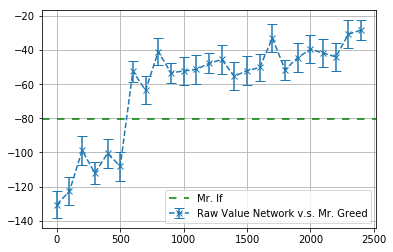

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator,MultipleLocator

t=[0     ,100   ,200  ,300   ,400   ,500   ,600  ,700  ,800  ,900  ,1000 ,1100 ,1200 ,
  1300 ,1400 ,1500 ,1600 ,1700 ,1800 ,1900 ,2000 ,2100 ,2200 ,2300 ,2400 ,]
v=[-130.6,-122.7,-98.8,-112.1,-100.6,-108.1,-52.4,-63.6,-40.9,-53.3,-52.3,-51.3,-47.8,
  -45.5,-55.3,-52.1,-50.2,-33.0,-51.5,-44.4,-39.5,-41.7,-44.0,-30.6,-28.3,]
e=[7.8   ,8.3   ,8.7  ,6.2   ,8.7   ,8.6   ,6.1  ,8.2  ,8.1  ,5.9  ,8.4  ,8.3  ,5.9  ,
  8.5  ,8.3  ,8.5  ,8.1  ,8.2  ,5.8  ,8.5  ,8.2  ,8.1  ,8.1  ,8.1  ,5.7  ,]

fig=plt.figure()
#fig.set_size_inches(4,3)
ax1=fig.subplots(1)
#ax1.plot()
ax1.errorbar(t,v,yerr=e,fmt='x--',capsize=5,label="Raw Value Network v.s. Mr. Greed")
ax1.axhline(y=-80.3,dashes=(5,5),c='g',label="Mr. If")
ax1.grid(True,which='both',axis='x')
ax1.grid(True,which='both',axis='y')
ax1.legend()#loc=
#plt.title("")
plt.show()

### MrGreed Note in 2020 July

MrGreed只看重眼前利益（这一圈的收益），不会用历史估计对手手牌（但是会考虑断章），也不会考虑自己之后怎么办。

MrGreed是用递归的方法定义的，首先，如果他是最后一个出牌的，他可以按照他的价值观（BURDEN_DICT）知道自己该怎么打。
如果他是倒数第二个则对可能的牌的分布采样，并假定最后一个人和自己打法一致，进而判断自己该怎么打。一直递归到第一个打的。

MrGreed不会再把猪塞给队友了。MrGreed会部分地考虑队友的感受，比如该它打牌，知道队友断某一门，自己又有这一门最小的，他就会打这一门好舒缓队友的压力。

MrGreed 在采样为10时对战 MrRandom，对战局数为256x4时, `0+2 - 1+3: 272.01 7.48`. MrGreed 在采样为10时对战 MrIf，对战局数为256x4时, `0+2 - 1+3: 70.78 8.41`.

每次模拟挑选的可能数N是MrGreed的重要可调参数，理论上N越大MrGreed越强。
为了研究N对MrGreed强弱的具体影响，改变不同的 N 让 MrGreed 和 MrIf 对战，记录他们的分差

N     |5    |10   |20   |30   |40
------|:---:|:---:|:---:|:---:|:-:
vs If |63.6 |70.8 |80.8 |82.4 |太卡了，不可行
Sigma |8.7  |8.4  |8.5  |8.3  |/

发牌的抽样算法是速度的瓶颈，换用 发牌-交换 算法之后，对其强弱和速度测试如下。
发牌-交换 算法是先随机发牌直到发到合法的，再在这个基础上不断交换获得一系列合法发牌的算法。
可见“发牌-交换”算法让MrGreed变稳定了，但是变菜了，不过这个菜是可以用N的增加来弥补的。

N     |5    |10   |20   |30   |40   |50   |60
------|:---:|:---:|:---:|:---:|:---:|:---:|:-:
vs If |51.8 |50.2 |68.61|74.9 |76.1 |86.5 |78.2
Sigma |8.4  |8.3  |8.3  |8.4  |8.2  |8.0  |8.7
t(s)  |34   |62   |117  |178  |223  |285  |343

最早版本的MrGreed的价值观是不对的，现在做如下改进：1.C10的含义不再是-60而是真实的乘二；2.SA当猪已经打出就不在可怕。
于是他就能：1.在自己得了羊并且红桃和猪打得差不多时主动去抢变压器；2.知道对手的某一个人有大负分，就把变压器给他；3.知道队友有更多负分，就主动得变压器；
4.在猪已经出过的情况下不那么着急出手SA。理论上这会让他更强。我还更新了BURDEN_DICT，做了些调整。
分数提高并不多，可能是在细枝末节优化意义不大，也可能是我哪里代码写错了，毕竟这部分不好实现，写错了但能跑也有可能。

N     |5    |10   |20   |30
------|:---:|:---:|:---:|:---:
vs If |56.8 |60.0 |80.0 |86.2
Sigma |8.5  |8.0  |7.7  |8.0
t(s)  |44   |85   |166  |244

再加入一些人类经验：开始时打短的，结果明显变强了。

N     |5    |10   |20
------|:---:|:---:|:---:
vs If |57.7 |80.1 |96.5
Sigma |7.9  |8.1  |8.0

再改进：自己有猪时猪圈也淡然处之.没变强也没变弱吧。

N     |5    |10   |20
------|:---:|:---:|:---:
vs If |72.7 |81.1 |89.3
Sigma |7.9  |7.9  |7.7

### Appendix A: MrRandom 和 MrIf 的详细统计信息
__第一个数字（比如下面第一行的-64.01）是平均每局得分，第二个（比如110.97）是得分的方差__

__详细统计信息可以用于纠错__

四个Mr. Random打1024x16局：
```
20/07/01 23:05:30 214 [INFO,stat_random:114] -64.01 110.97
20/07/01 23:05:30 217 [INFO,stat_random:114] -63.44 111.01
20/07/01 23:05:30 220 [INFO,stat_random:114] -62.29 109.91
20/07/01 23:05:30 223 [INFO,stat_random:114] -64.00 110.39
```

教会Mr. If先把短的花色打光再贴牌

    如果随便出
        从所剩张数少的花色开始，如果没有“危险牌”，就出这个花色大的
        尽量不出猪、猪圈、变压器、比变压器大的、红桃AK、羊
    如果是贴牌，按危险列表依次贴，没有危险列表了，贴短的
```
三个Mr. Random和一个Mr. If打128x16局：
20/07/02 12:30:33 370 [INFO,stat_random:116] -35.82 96.22
20/07/02 12:30:33 371 [INFO,stat_random:116] -75.61 117.02
20/07/02 12:30:33 372 [INFO,stat_random:116] -72.72 112.31
20/07/02 12:30:33 372 [INFO,stat_random:116] -73.02 112.53
两个Mr. Random和两个Mr. If打128x16局（邻）：
20/07/02 12:38:59 021 [INFO,stat_random:119] -42.78 95.74
20/07/02 12:38:59 022 [INFO,stat_random:119] -43.41 100.92
20/07/02 12:38:59 022 [INFO,stat_random:119] -90.96 125.14
20/07/02 12:38:59 023 [INFO,stat_random:119] -85.41 122.00
两个Mr. Random和两个Mr. If打128x16局（对）：
20/07/02 14:18:51 948 [INFO,stat_random:119] -42.74 99.39
20/07/02 14:18:51 949 [INFO,stat_random:119] -88.81 121.30
20/07/02 14:18:51 950 [INFO,stat_random:119] -44.93 97.94
20/07/02 14:18:51 950 [INFO,stat_random:119] -82.64 123.54
一个Mr. Random和三个Mr. If打128x16局：
20/07/02 12:39:33 774 [INFO,stat_random:119] -53.20 107.56
20/07/02 12:39:33 774 [INFO,stat_random:119] -56.47 106.12
20/07/02 12:39:33 775 [INFO,stat_random:119] -52.94 109.28
20/07/02 12:39:33 776 [INFO,stat_random:119] -102.85 131.01
四个Mr. If打128x16局：
20/07/02 12:40:30 030 [INFO,stat_random:119] -63.34 114.67
20/07/02 12:40:30 031 [INFO,stat_random:119] -67.39 121.14
20/07/02 12:40:30 031 [INFO,stat_random:119] -68.96 122.06
20/07/02 12:40:30 032 [INFO,stat_random:119] -68.15 114.92
```

教会Mr. If红桃草花黑桃方片的基本打法

    如果是猪牌并且我的猪剩两张以上
        如果我有猪并且有人打过猪圈，贴猪
        如果我是最后一个并且前面没认出过猪，打除了猪之外最大的
        其他情况打不会得猪的
    如果是变压器并且草花剩两张以上
        类似于猪
    如果是羊并且剩两张以上
        如果我是最后一个，我有羊，并且前面的牌都比羊小，打羊
        其他情况打不是羊的最大的
    如果是红桃，尽可能躲，捡大的贴
```
三个Mr. Random和一个Mr. If打128x16局：
20/07/02 14:15:45 410 [INFO,stat_random:119] -2.30 69.36
20/07/02 14:15:45 411 [INFO,stat_random:119] -83.91 118.71
20/07/02 14:15:45 411 [INFO,stat_random:119] -88.05 121.81
20/07/02 14:15:45 412 [INFO,stat_random:119] -91.43 123.46
两个Mr. Random和两个Mr. If打128x16局（邻）：
20/07/02 14:16:11 780 [INFO,stat_random:119] -18.26 80.08
20/07/02 14:16:11 780 [INFO,stat_random:119] -17.73 79.66
20/07/02 14:16:11 781 [INFO,stat_random:119] -117.96 138.31
20/07/02 14:16:11 782 [INFO,stat_random:119] -125.02 141.88
两个Mr. Random和两个Mr. If打128x16局（对）：
20/07/02 14:17:38 259 [INFO,stat_random:119] -22.49 81.92
20/07/02 14:17:38 259 [INFO,stat_random:119] -115.66 141.13
20/07/02 14:17:38 260 [INFO,stat_random:119] -19.26 77.73
20/07/02 14:17:38 261 [INFO,stat_random:119] -118.54 140.22
一个Mr. Random和三个Mr. If打128x16局：
20/07/02 14:16:33 123 [INFO,stat_random:119] -42.94 96.30
20/07/02 14:16:33 123 [INFO,stat_random:119] -37.52 101.65
20/07/02 14:16:33 124 [INFO,stat_random:119] -38.59 96.96
20/07/02 14:16:33 125 [INFO,stat_random:119] -169.94 167.55
四个Mr. If打128x16局：
20/07/02 14:16:53 298 [INFO,stat_random:119] -69.90 121.73
20/07/02 14:16:53 298 [INFO,stat_random:119] -66.86 120.47
20/07/02 14:16:53 299 [INFO,stat_random:119] -70.22 121.32
20/07/02 14:16:53 300 [INFO,stat_random:119] -69.22 121.62
```